# Shape Descriptor Index (SDI): Biomarker Analysis for ICU Mortality Prediction in COVID-19

## 📋 Project Overview

This Jupyter notebook (`ipynb`) documents and reproduces the complete statistical analysis conducted for the research study **"Shape Descriptor Index (SDI) reveals nine routine biomarkers predicting ICU mortality in Chilean COVID-19 patients: distributional analysis outperforms conventional statistics"**.

The analysis implements an innovative methodology called the **Shape Descriptor Index (SDI)**, designed to identify prognostic biomarkers through the integration of statistical significance and morphological divergence in the distributions of survivors versus non-survivors.

## 🎯 Study Objectives

To evaluate whether a universally available panel of biomarkers, measured at the time of intensive care unit (ICU) admission, can predict hospital mortality among Chilean patients with severe COVID-19 during the pandemic peak (January–September 2021).

## 🔍 Study Population

- **Cohort**: 98 patients with severe COVID-19 admitted to Chilean ICUs
- **Observed mortality**: 37% (36 non-survivors), exceeding European benchmarks (25–30%)
- **Single-point analysis**: ICU admission measurements only, eliminating serial averaging bias

## ⚙️ SDI Methodology

The **Shape Descriptor Index** integrates three key dimensions:

1. **Statistical significance** (*p* < 0.10) using:
   - Student's *t*-test (normally distributed data)
   - Mann–Whitney U test (non-normally distributed data)

2. **Morphological divergence** (≥25%) quantified through:
   - **Kurtosis (U)**: Concentration of values around the mean
   - **Interquartile range (W)**: Dispersion of the central 50% of data

3. **Effect size** for clinical relevance:
   - Cohen's *d* (parametric comparisons)
   - Cliff's Delta (non-parametric comparisons)

## 🧬 Biomarker Categories Analyzed

A comprehensive panel of **58 routine analytes** was evaluated across 5 categories:

1. **Biochemical parameters** (Creatinine, AST, Glucose, etc.)
2. **Cardiac markers and coagulation parameters** (Troponin I, LDH, Platelets, etc.)
3. **Hematological parameters** (Immature granulocytes, Leukocytes, etc.)
4. **Blood gas and electrolyte parameters** (pO₂, SaO₂, pH, etc.)
5. **Inflammatory parameters** (CRP, Ferritin, etc.)

## 📊 Analytical Workflow

This notebook implements the following workflow:

1. **Data extraction and consolidation** from SQLite database
2. **Descriptive statistics calculation** for each biomarker
3. **Normality assessment** using Shapiro–Wilk test
4. **Intergroup comparisons** using parametric and non-parametric tests
5. **Effect size calculation** (Cohen's *d*, Cliff's Delta)
6. **SDI application** to identify prognostic biomarkers
7. **Results visualization** using violin plots

## 🎯 Key Findings

The analysis identified **9 SDI-positive biomarkers** with distributional divergence ≥25%:

| Biomarker | SDI (%) | Clinical Significance |
|-----------|---------|----------------------|
| LDH | 35.7% | Multiorgan injury |
| Troponin I | 33.3% | Myocardial damage |
| Creatinine | 33% | Acute kidney injury |
| SaO₂ | 28% | Severe hypoxemia |
| pO₂ | 28% | Severe hypoxemia |
| Immature granulocytes | 26.3% | Bone marrow stress |
| AST | 25.9% | Hepatocellular injury |
| Total CK | 25.9% | Rhabdomyolysis |
| Platelets | 25% | Reactive thrombocytopenia |

## 💡 Methodological Innovation

The SDI framework addresses **five recurrent limitations** in COVID-19 biomarker research:

1. Conflation of hospitalized versus ICU populations
2. Serial measurements introducing temporal bias
3. Repeated observations violating statistical independence
4. Exhaustive (>50 analyte) panels lacking pragmatic utility
5. Exclusive p-value dependence neglecting distributional characteristics

## 🛠️ Notebook Structure

This document is organized into sections that precisely reproduce the original script analysis, with step-by-step explanations, visualizations, and references to the corresponding scientific manuscript.

---

*This analysis was developed using Python 3.x with the following libraries: pandas, numpy, scipy, matplotlib, seaborn, and SQLite3. All data have been anonymized, and the study was approved by the corresponding Scientific Ethics Committee.*



---



---

# 1. Database Initialization and Relational Model Visualization

Critical Configuration Note: The path variable below must be modified to match the exact directory location where you have stored the COVID_First_measurements_records.sqlite database file on your system. This step is essential for successful data loading and all subsequent analyses. Please verify your file path before proceeding.

RELATIONAL MODEL OF /content/drive/Othercomputers/Mi PC/PAPER_COVID_OCT_2025/repogit/COVID_First_measurements_records.sqlite


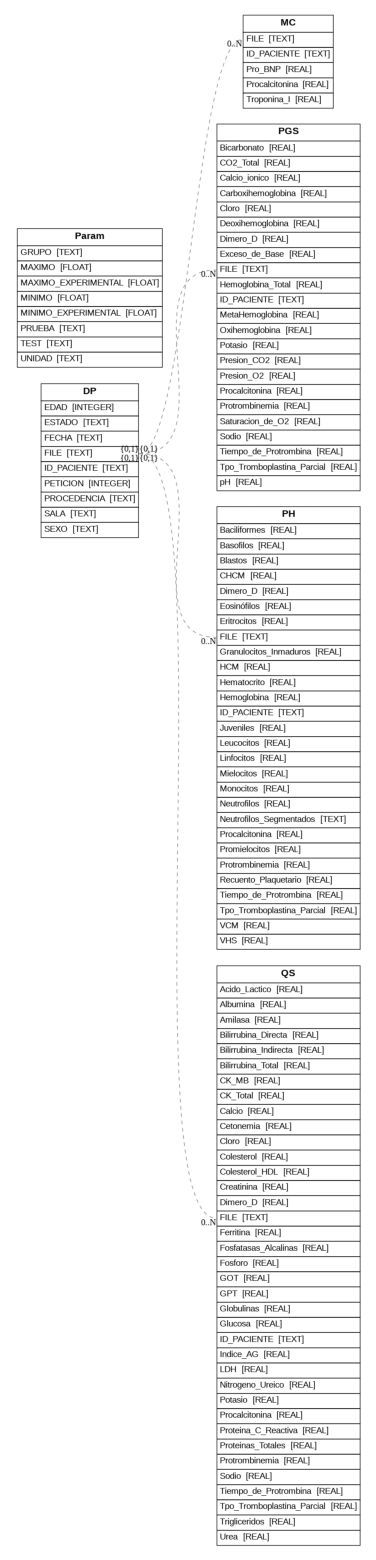

In [88]:
# Importation of required libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import stats
import numpy as np
import seaborn as sns

# Conditional import of eralchemy; install if not present
try:
    from eralchemy import render_er
except ImportError:
    # Install the missing eralchemy package
    !pip install eralchemy
    from eralchemy import render_er

# Database file location.
# REPLACE with the path where you have stored the COVID_First_measurements_records.sqlite database.
path='/content/drive/Othercomputers/Mi PC/PAPER_COVID_OCT_2025/repogit/'
db_file = path+'COVID_First_measurements_records.sqlite'

# Generation and display of the database relational model
print(f"RELATIONAL MODEL OF {db_file}")

# Generate Entity-Relationship diagram and save as 'MR.png'
render_er(f"sqlite:///{db_file}", "MR.png")

# Load the generated diagram image
img = mpimg.imread('MR.png')

# Create a figure with a specific size for display
fig, ax = plt.subplots(figsize=(20, 20))  # Figure size specified in inches
ax.imshow(img)

# Hide the plot axes for a cleaner visualization
ax.axis('off')

# Display the generated diagram
plt.show()

# 2. Core Analytical Functions Implementation

This section establishes the complete statistical framework for biomarker analysis. The following functions provide all necessary tools for data extraction, statistical comparison, effect size quantification, and the innovative Shape Descriptor Index (SDI) calculation. These functions form the computational backbone of the entire analysis pipeline and will be used repeatedly throughout this notebook.

In [71]:
def query(sql_query):
    """
    Executes a SQL query and returns the result as a DataFrame.

    Parameters:
    sql_query (str): The SQL query to be executed

    Returns:
    pandas.DataFrame: Query results, or None if an error occurs
    """
    try:
        # Establish connection to the SQLite database
        conn = sqlite3.connect(db_file)

        # Execute query and load results into a pandas DataFrame
        df = pd.read_sql_query(sql_query, conn)
        return df

    except sqlite3.Error as e:
        # Handle database connection or query execution errors
        print(f"An error occurred: {e}")
        return None

    finally:
        # Ensure database connection is properly closed
        if 'conn' in locals() and conn:
            conn.close()
            # Optional: print("\nDatabase connection closed.")

def retorna_dataframe_de_los(estado):
    """
    Retrieves patient data from the database based on survival status and
    consolidates biomarker measurements from multiple parameter tables.

    Parameters:
    estado (str): Patient survival status ('survivor' or 'not-survivor')

    Returns:
    pandas.DataFrame: Consolidated patient data with translated column names
    """
    # Retrieve patient information from the database based on survival status
    sql = f"""SELECT
        ID_PACIENTE, FILE, FECHA
    FROM DP
    WHERE ESTADO = '{estado}'
    GROUP BY ID_PACIENTE;"""
    df = query(sql)

    # Initialize an empty list to store consolidated patient data records
    all_patient_records = []

    # Iterate through each patient to retrieve cardiac marker data from table MC
    for index, row in df.iterrows():
        patient_id = row['FILE']
        current_patient_record = {'ID': patient_id, 'GROUP': 'MC'}

        # Query for cardiac biomarkers and coagulation parameters (MC table)
        sql = f"SELECT * FROM MC WHERE FILE='{patient_id}'"
        df_MC = query(sql)

        # Process data if patient has entries in the MC table
        if not df_MC.empty:
            for index_MC, row_MC in df_MC.iterrows():
                # Add each parameter value to the patient's record dictionary
                for param in df_MC.columns:
                    if param != "ID_PACIENTE" and param != "FILE":
                        current_patient_record[param] = row_MC[param]

        # Query for pH, electrolyte and blood gas parameters (PGS table)
        sql = f"SELECT * FROM PGS WHERE FILE='{patient_id}'"
        df_MC = query(sql)
        if not df_MC.empty:
            for index_MC, row_MC in df_MC.iterrows():
                for param in df_MC.columns:
                    if param != "ID_PACIENTE" and param != "FILE":
                        current_patient_record[param] = row_MC[param]

        # Query for hematological parameters (PH table)
        sql = f"SELECT * FROM PH WHERE FILE='{patient_id}'"
        df_MC = query(sql)
        if not df_MC.empty:
            for index_MC, row_MC in df_MC.iterrows():
                for param in df_MC.columns:
                    if param != "ID_PACIENTE" and param != "FILE":
                        current_patient_record[param] = row_MC[param]

        # Query for blood biochemical parameters (QS table)
        sql = f"SELECT * FROM QS WHERE FILE='{patient_id}'"
        df_MC = query(sql)
        if not df_MC.empty:
            for index_MC, row_MC in df_MC.iterrows():
                for param in df_MC.columns:
                    if param != "ID_PACIENTE" and param != "FILE":
                        current_patient_record[param] = row_MC[param]

        # Append the completed patient record to the consolidated list
        all_patient_records.append(current_patient_record)

    # Create the stage_1 DataFrame from the list of patient record dictionaries
    stage_1 = pd.DataFrame(all_patient_records)

    # Translate Spanish column names to English using the Param reference table
    current_columns = stage_1.columns.tolist()
    column_name_mapping = {}

    for current_column_name in current_columns:
        # Preserve 'ID' and 'GROUP' columns as they are not in the Param table
        if current_column_name in ['ID', 'GROUP']:
            column_name_mapping[current_column_name] = current_column_name
            continue

        # Query the Param table for English equivalents of Spanish parameter names
        sql = f"SELECT TEST FROM Param WHERE PRUEBA = '{current_column_name}'"
        df_result = query(sql)

        if not df_result.empty and not pd.isna(df_result.iloc[0]['TEST']):
            new_name = df_result.iloc[0]['TEST']
            column_name_mapping[current_column_name] = new_name
        else:
            # Retain original name if no translation is found
            column_name_mapping[current_column_name] = current_column_name

    # Apply the column name translations to the DataFrame
    stage_1 = stage_1.rename(columns=column_name_mapping)

    # Optional debugging statements (commented out):
    # print("Updated column names in stage_1:", stage_1.columns.tolist())
    # print("\nFirst 5 rows of stage_1 with updated column names:")
    # print(stage_1.head())
    return stage_1

def cohens_d(grupo1, grupo2):
    """
    Calculates Cohen's d as a measure of effect size between two groups.

    Cohen's d quantifies the standardized difference between two group means,
    commonly used in statistical analysis to assess the magnitude of an effect.

    Parameters:
    grupo1 (array-like): Data values for the first group
    grupo2 (array-like): Data values for the second group

    Returns:
    float: Cohen's d effect size measure

    Formula:
    d = (mean1 - mean2) / pooled_std
    where pooled_std = sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1 + n2 - 2))
    """
    # Remove missing values from both datasets
    datos1 = grupo1.dropna()
    datos2 = grupo2.dropna()

    # Calculate sample sizes for each group
    n1 = len(datos1)
    n2 = len(datos2)

    # Compute arithmetic means for both groups
    mean1 = datos1.mean()
    mean2 = datos2.mean()

    # Calculate sample variances (using ddof=1 for unbiased sample variance)
    var1 = datos1.var(ddof=1)  # ddof=1 provides Bessel's correction (n-1 denominator)
    var2 = datos2.var(ddof=1)

    # Compute pooled standard deviation (combined estimate of population standard deviation)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    # Calculate Cohen's d: standardized mean difference between groups
    d = (mean1 - mean2) / pooled_std
    return d

def cliffs_delta(grupo1, grupo2):
    """
    Calculates Cliff's Delta, a non-parametric measure of effect size.

    Cliff's Delta quantifies the probability that a randomly selected value
    from one group is greater than a randomly selected value from another group,
    minus the reverse probability. The result ranges from -1 to 1.

    Parameters:
    grupo1 (array-like): Data values for the first group
    grupo2 (array-like): Data values for the second group

    Returns:
    float or None: Cliff's Delta value between -1 and 1, or None if either group is empty

    Interpretation:
    - |delta| > 0.474: Large effect (overlap < 0.33)
    - |delta| > 0.33: Medium effect (overlap < 0.45)
    - |delta| > 0.147: Small effect (overlap < 0.64)
    - |delta| ≤ 0.147: Negligible effect
    """
    # Remove missing values and convert to numpy arrays for efficient processing
    datos1 = grupo1.dropna().values
    datos2 = grupo2.dropna().values

    # Determine sample sizes for each group
    n1 = len(datos1)
    n2 = len(datos2)

    # Return None if either group contains no valid data points
    if n1 == 0 or n2 == 0:
        return None

    # Initialize counters for pairwise comparisons
    mayor = 0  # Counts instances where group1 > group2
    menor = 0  # Counts instances where group1 < group2

    # Perform all pairwise comparisons between the two groups
    for x1 in datos1:
        for x2 in datos2:
            if x1 > x2:
                mayor += 1
            elif x1 < x2:
                menor += 1
            # Note: Ties (x1 == x2) are not counted in either category

    # Calculate Cliff's Delta: (P(X1 > X2) - P(X1 < X2))
    delta = (mayor - menor) / (n1 * n2)
    return delta

def evaluador_de_test(test, p_value, shapiro_g1=None, shapiro_g2=None):
    """
    Evaluates statistical test results and returns interpretation strings.

    This function provides standardized interpretations for various statistical
    tests based on p-values and Shapiro-Wilk test results for normality assessment.

    Parameters:
    test (str): Type of statistical test ('shapiro', 'Mann-Whitney', 'T-test', 'Cliffs', 'Cohens')
    p_value (float): The p-value from the statistical test
    shapiro_g1 (float, optional): Shapiro-Wilk p-value for group 1 (normality test)
    shapiro_g2 (float, optional): Shapiro-Wilk p-value for group 2 (normality test)

    Returns:
    str or None: Interpretation string or None if conditions are not met
    """

    # Shapiro-Wilk normality test evaluation
    if test == "shapiro":
        if p_value >= 0.10:
            return "Normality accepted"
        elif 0.05 <= p_value < 0.10:
            return "Questionable normality"
        elif 0.01 <= p_value < 0.05:
            return "Probably non-normal"
        else:  # p_value < 0.01
            return "Clearly non-normal"

    # Mann-Whitney U test evaluation (non-parametric alternative to t-test)
    if test == "Mann-Whitney":
        # Apply Mann-Whitney only if data is non-normal (Shapiro p-value < 0.10)
        if shapiro_g1 < 0.10 or shapiro_g2 < 0.10:
            if p_value < 0.001:
                return "***"  # Highly significant (p < 0.001)
            elif p_value < 0.01:
                return "**"   # Very significant (p < 0.01)
            elif p_value < 0.05:
                return "*"    # Significant (p < 0.05)
            elif p_value < 0.10:
                return "."    # Marginally significant (p < 0.10)
            else:
                return "ns"   # Not significant
        else:
            return None       # Data appears normal; consider parametric test instead

    # Student's t-test evaluation (parametric test for normal data)
    if test == "T-test":
        # Apply t-test only if data is normal (Shapiro p-value >= 0.10 for both groups)
        if shapiro_g1 >= 0.10 and shapiro_g2 >= 0.10:
            if p_value < 0.001:
                return "***"  # Highly significant (p < 0.001)
            elif p_value < 0.01:
                return "**"   # Very significant (p < 0.01)
            elif p_value < 0.05:
                return "*"    # Significant (p < 0.05)
            elif p_value < 0.10:
                return "."    # Marginally significant (p < 0.10)
            else:
                return "ns"   # Not significant
        else:
            return None       # Data appears non-normal; consider non-parametric test instead

    # Cliff's Delta effect size interpretation (non-parametric effect size)
    # Note: Parameter shapiro_g1 is repurposed as Mann-Whitney p-value for this case
    if test == "Cliffs" and shapiro_g1 < 0.10:
        if p_value is not None:
            abs_delta = abs(p_value)
            if abs_delta < 0.147:
                return "Negligible"
            elif abs_delta < 0.330:
                return "Small"
            elif abs_delta < 0.474:
                return "Medium"
            else:
                return "Large"
        else:
            return None

    # Cohen's d effect size interpretation (parametric effect size)
    # Note: Parameter shapiro_g1 is repurposed as t-test p-value for this case
    if test == "Cohens" and shapiro_g1 < 0.10:
        if p_value is not None:
            abs_delta = abs(p_value)
            if abs_delta < 0.2:
                return "Negligible"
            elif abs_delta < 0.5:
                return "Small"
            elif abs_delta < 0.8:
                return "Medium"
            else:
                return "Large"
        else:
            return None

    # Return None if no test condition is matched
    return None

def calcular_SDI(N_sobrevivientes, N_muertos, p_value_shapiro_vivos, p_value_shapiro_muertos, p_value_MWU, p_value_T, kurtosis_sobrevivientes, kurtosis_muertos, iqr_sobrevivientes, iqr_muertos, Z4):
    """
    Calculates the Shape Descriptor Index (SDI) classification for a biomarker.

    This function implements the SDI framework described in the study 'Shape Descriptor Index (SDI) reveals nine routine biomarkers...'.
    It evaluates whether a biomarker demonstrates both statistical significance and substantial distributional divergence
    between survivor and non-survivor groups, using predefined thresholds for clinical relevance.

    Parameters:
    N_sobrevivientes (int): Number of survivors in the sample for the analyte
    N_muertos (int): Number of non-survivors in the sample for the analyte
    p_value_shapiro_vivos (float): Shapiro-Wilk p-value for normality test in survivor group
    p_value_shapiro_muertos (float): Shapiro-Wilk p-value for normality test in non-survivor group
    p_value_MWU (float): p-value from Mann-Whitney U test (non-parametric comparison)
    p_value_T (float): p-value from Student's t-test (parametric comparison)
    kurtosis_sobrevivientes (float): Kurtosis value for survivor distribution
    kurtosis_muertos (float): Kurtosis value for non-survivor distribution
    iqr_sobrevivientes (float): Interquartile range (IQR) for survivor distribution
    iqr_muertos (float): Interquartile range (IQR) for non-survivor distribution
    Z4 (float): Predefined divergence threshold (default: 25%)

    Returns:
    str or float:
        - "YES:[Porcentaje_muertos]" if analyte meets SDI-positive criteria (statistical significance + morphological divergence)
        - "NO:[Porcentaje_muertos]" if analyte has adequate representation but lacks morphological divergence
        - [Porcentaje_muertos] (float) if analyte lacks adequate non-survivor representation
        - None if analyte lacks statistical significance despite adequate representation

    Methodology (as per manuscript):
    1. Requires adequate non-survivor representation (≥Z4% of total sample)
    2. Assesses statistical significance (p < 0.10) using appropriate test:
       - t-test when both groups are normal (Shapiro p ≥ 0.10)
       - Mann-Whitney U when normality assumptions are violated
    3. Quantifies morphological divergence using relative differences in:
       - Kurtosis (U): measures tail behavior and extreme value concentration
       - Interquartile range (W): measures dispersion in central 50% of data
    4. Classifies as SDI-positive if statistical significance AND either U or W > Z4
    """

    # Calculate non-survivor percentage for sample representativeness assessment
    Porcentaje_muertos = (N_muertos * 100) / (N_sobrevivientes + N_muertos)

    # Step 1: Check if analyte has adequate non-survivor representation
    # (SDI evaluation restricted to analytes with stable shape estimates)
    if Porcentaje_muertos >= Z4:

        # Step 2: Assess statistical significance (p < 0.10 threshold)
        # Uses t-test for normal distributions, Mann-Whitney U for non-normal
        # This addresses p-value exclusivity limitation mentioned in Introduction
        if (((p_value_shapiro_vivos >= 0.10 and p_value_shapiro_muertos >= 0.10) and p_value_T < 0.1) or p_value_MWU < 0.1):

            # Step 3a: Calculate kurtosis divergence (U metric)
            # Kurtosis sensitivity to extreme responses reflects pathophysiological heterogeneity
            minimo_M = min(kurtosis_sobrevivientes, kurtosis_muertos)
            maximo_M = max(kurtosis_sobrevivientes, kurtosis_muertos)
            U8 = 100 - ((minimo_M * 100) / maximo_M)

            # Step 3b: Calculate IQR divergence (W metric)
            # IQR robustness to outliers characterizes central distribution spread
            minimo_I = min(iqr_sobrevivientes, iqr_muertos)
            maximo_I = max(iqr_sobrevivientes, iqr_muertos)
            W8 = 100 - ((minimo_I * 100) / maximo_I)

            # Step 4: Apply SDI classification criteria
            # Requires BOTH statistical significance AND substantial morphological divergence
            # 25% threshold balances sensitivity and specificity (per Methodological Justification)
            if U8 > Z4 or W8 > Z4:
                # SDI-positive: Statistically significant with clinically relevant distributional divergence
                # Example: Creatinine (SDI=33%), Troponin I (SDI=33.3%), LDH (SDI=35.7%)
                return f"YES:{Porcentaje_muertos}"
            else:
                # Statistically significant but insufficient morphological divergence
                return f"NO:{Porcentaje_muertos}"
        else:
            # Insufficient statistical significance (p ≥ 0.10) despite adequate sample representation
            return None
    else:
        # Inadequate non-survivor representation for reliable SDI assessment
        # Returns percentage for transparency (e.g., analytes with n<10 non-survivors)
        return Porcentaje_muertos

# 2. Core Analytical Functions Implementation

This section establishes the complete statistical framework for biomarker analysis. The following functions provide all necessary tools for data extraction, statistical comparison, effect size quantification, and the innovative Shape Descriptor Index (SDI) calculation. These functions form the computational backbone of the entire analysis pipeline and will be used repeatedly throughout this notebook.

In [89]:
# Retrieve a DataFrame containing consolidated biomarker data for survivors
# This implements the single-point ICU admission analysis methodology described in the manuscript,
# addressing the limitation of "serial measurements introducing temporal averaging bias"
sobrevivientes = retorna_dataframe_de_los("survivor")

# Retrieve a DataFrame containing consolidated biomarker data for non-survivors
# The 37% ICU mortality rate in this cohort (36 non-survivors out of 98 total patients)
# significantly exceeds European benchmarks (25-30%), as noted in the Results section
muertos = retorna_dataframe_de_los("non-survivor")

# Export the survivor DataFrame to an Excel file for archival and supplementary documentation
# File path follows the project directory structure established for data management
# This exported data corresponds to the 62 survivors analyzed in the study (Table 1)
sobrevivientes.to_excel(path+'survivors.xlsx', index=False)

# Export the non-survivor DataFrame to an Excel file for archival and supplementary documentation
# This dataset contains the 36 non-survivors (37% mortality) with their admission biomarker profiles
# These exported files provide the raw data underlying the SDI analysis presented in the manuscript
muertos.to_excel(path+'non-survivors.xlsx', index=False)

In [77]:
sobrevivientes

,ID,GROUP,TROPONIN I,Pro-BNP (Pro-Brain Natriuretic Peptide),Procalcitonin,Oxygen Pressure (pO2),Oxygen Saturation (SaO2),pH,Carbon Dioxide Pressure (pCO2),Base Excess,...,Calcium,Total Proteins,Globulins,Albumin/Globulin ratio,Amylase,Cholesterol,Direct Bilirubin,Indirect Bilirubin,Ketonemia,HDL Cholesterol
0,1876fcc8d5a23d77c85417402d495065,MC,2.6,NaN,NaN,59.6,92.4,7.430,32.4,-2.3,...,NaN,8.2,4.5,0.8,NaN,NaN,NaN,NaN,NaN,NaN
1,513d6ef7067d95130c65cab6a4bf8be0,MC,0.0,NaN,NaN,113.2,98.6,7.472,27.3,-2.6,...,NaN,7.4,3.5,1.1,NaN,NaN,NaN,NaN,NaN,NaN
2,105d111d31b6675b96657e04076b0ffd,MC,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.9,3.4,1.3,NaN,NaN,NaN,NaN,NaN,NaN
3,42c2e8e8231377995ce164a2cfe087c5,MC,NaN,NaN,NaN,107.0,98.2,7.448,34.6,-0.1,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3eff52ba694b7a9d3d678e4fc2ca7d49,MC,NaN,NaN,NaN,78.1,95.3,7.353,45.5,-1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,ef30478fd3c22f79cc099df6cbf779b3,MC,NaN,20.0,NaN,96.5,96.7,7.283,48.4,-4.8,...,NaN,8.2,5.0,0.6,58.0,NaN,NaN,NaN,1.0,NaN
57,feea98deaff50d657b3c27372452293b,MC,0.0,NaN,NaN,76.1,96.1,7.456,34.0,0.2,...,NaN,7.8,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
58,a6a1b3fae3edeacc352cf9507d6d8400,MC,NaN,NaN,NaN,113.7,98.3,7.405,34.3,-2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,a5832c03c016690039d2f5242704d168,MC,NaN,NaN,NaN,65.9,93.9,7.429,31.8,-2.7,...,NaN,7.9,4.4,0.8,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
muertos

,ID,GROUP,Oxygen Pressure (pO2),Oxygen Saturation (SaO2),pH,Carbon Dioxide Pressure (pCO2),Base Excess,Bicarbonate (HCO3-),Total CO2,Sodium,...,Calcium,Total Proteins,Globulins,Albumin/Globulin ratio,Amylase,Cholesterol,Direct Bilirubin,Indirect Bilirubin,Ketonemia,HDL Cholesterol
0,f98567400c84ac0ac2b35adf1de5e0a3,MC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,d8584f630ad43550c2b4b9efb85adea6,MC,82.5,96.6,7.367,49.7,1.7,27.9,29.4,138.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21ecc56b39a173dc50eee0c39ce88e71,MC,58.4,93.6,7.514,36.9,5.9,29.0,30.2,150.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5c6e797b0ab1c5d1017158e9d6795910,MC,75.3,96.1,7.454,30.8,-2.0,21.2,22.1,NaN,...,8.5,6.8,3.3,1.1,NaN,NaN,NaN,NaN,NaN,NaN
4,f61d3695c43e0e6428f09b1156e038a3,MC,88.5,97.5,7.477,39.6,4.7,28.6,29.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.3,NaN,NaN
5,f50699adcdff1c0f1e0cf0ff46d0f6f6,MC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,b33c4e2f782bf5050bdc01c475913c4e,MC,26.5,50.8,7.395,39.5,-1.0,23.7,24.9,NaN,...,NaN,7.3,3.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
7,d73846af116b22aa13c388479b4c6dd3,MC,67.8,92.8,7.298,44.2,-5.1,21.2,22.5,153.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,d5999e4e1d7b3639dced8d12d9b6f019,MC,66.4,87.8,7.067,105.3,-2.2,29.6,32.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,dcab5fa54e6c2cbf0ba8e38595ab5ff8,MC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#4. Complete Statistical Analysis Execution

This section performs the comprehensive statistical analysis for all 58 biomarkers. The code systematically computes descriptive statistics, normality assessments, comparative tests, effect sizes, and SDI classifications for each analyte. **This analysis generates the data for Supplementary Table 1 and provides the statistical foundation for Tables 2-5 in the manuscript**. The results are exported to an Excel file containing the complete biomarker-by-biomarker statistical profile.

In [90]:
# Comprehensive descriptive statistics calculation for all biomarkers
# This code generates the complete statistical analysis underlying Tables 2-5 and Supplementary Table 1
# Implements the comparative statistical framework described in "Statistical analysis" section
estadisticas = pd.DataFrame(columns=['GROUP',
'Lab. Test',
'Reference ranges',
'Survivors',
'Avg. survivors',
'Q1 Survivors',
'Q2 Survivors',
'Q3 Survivors',
'MEDIAN Survivors',
'IQR Survivors',
'Skewness Survivors',
'Kurtosis Survivors',
'Shapiro Test Survivors',
'Is Survivors Normal Dist.',
'Non-Survivors',
'Avg. Non-survivors',
'Q1 Non-Survivors',
'Q2 Non-Survivors',
'Q3 Non-Survivors',
'MEDIAN Non-Survivors',
'IQR Non-Survivors',
'Skewness Non-Survivors',
'Kurtosis Non-Survivors',
'Shapiro Test Non-Survivors',
'Is Non-Survivors Normal Dist.',
'Kolmogorov–Smirnov test',
'Mann-Whitney U test',
'Non-parametric significance',
'T-test',
'One-way ANOVA',
'parametric significance',
'Cohens d',
'Parametric effect',
'Cliffs Delta',
'Non-parametric effect',
'SDI'])

# Extract biomarker names (analytes) from survivors DataFrame, excluding metadata columns
# These represent the 58 routine analytes mentioned in "Material and methods"
nombres_analitos_sobrevivientes = sobrevivientes.columns.tolist() # Convert to list
nombres_analitos_sobrevivientes.remove('ID')
nombres_analitos_sobrevivientes.remove('GROUP')

# Iterate through each analyte to compute comprehensive statistical descriptors
# This loop generates the data for all 58 analytes across the 5 biomarker categories
for analito in nombres_analitos_sobrevivientes:
    lab_test = analito
    print("-" * 30)
    print(f"Lab. Test: {lab_test}")

    # Retrieve reference ranges and classification from Param table
    # Reference ranges provide clinical context for biomarker interpretation
    opt = query(f"SELECT GRUPO, MINIMO, MAXIMO, UNIDAD FROM Param WHERE TEST='{analito}'")
    try:
        Reference_ranges = f"{opt.MINIMO[0]} ~ {opt.MAXIMO[0]} {opt.UNIDAD[0]}"
        # Reference ranges contextualize observed values relative to normal physiology
        # as mentioned in "Data Visualization" section (horizontal blue lines in plots)
    except:
        print(f"********** ERROR WITH {lab_test} ******************")

    # Descriptive statistics for survivor group (n=62)
    survivors = sobrevivientes[analito].count()
    avg_survivors = sobrevivientes[analito].mean()

    # Descriptive statistics for non-survivor group (n=36, 37% mortality)
    no_survivors = muertos[analito].count()
    avg_no_survivors = muertos[analito].mean()

    # Quartile calculations for survivor distribution
    # These descriptors quantify central tendency and dispersion
    q1_sobrevivientes = sobrevivientes[analito].quantile(0.25)  # First quartile (25th percentile)
    q2_sobrevivientes = sobrevivientes[analito].quantile(0.50)  # Second quartile/Median (50th percentile)
    q3_sobrevivientes = sobrevivientes[analito].quantile(0.75)  # Third quartile (75th percentile)
    mediana_sobrevivientes = sobrevivientes[analito].median()    # Median (equivalent to Q2)
    iqr_sobrevivientes = q3_sobrevivientes - q1_sobrevivientes   # Interquartile range (central 50%)

    # Quartile calculations for non-survivor distribution
    q1_muertos = muertos[analito].quantile(0.25)  # First quartile (25th percentile)
    q2_muertos = muertos[analito].quantile(0.50)  # Second quartile/Median (50th percentile)
    q3_muertos = muertos[analito].quantile(0.75)  # Third quartile (75th percentile)
    mediana_muertos = muertos[analito].median()    # Median (equivalent to Q2)
    iqr_muertos = q3_muertos - q1_muertos          # Interquartile range (central 50%)

    # Distribution shape analysis for survivors
    # Kurtosis quantifies concentration around the mean (Fisher's definition, 0 = normal)
    skew_sobrevivientes = sobrevivientes[analito].skew()
    kurtosis_sobrevivientes = sobrevivientes[analito].kurtosis()

    # Distribution shape analysis for non-survivors
    skew_muertos = muertos[analito].skew()
    kurtosis_muertos = muertos[analito].kurtosis()

    # Normality assessment using Shapiro-Wilk test
    # Critical for selecting appropriate comparative statistical test
    # As described in "Statistical analysis": p ≥ 0.10 indicates acceptance of normality
    try:
        statistic, p_value_shapiro_vivos = stats.shapiro(sobrevivientes[analito].dropna())
    except:
        print("FAIL: shapiro")
    try:
        statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())
    except:
        print("FAIL: shapiro")

    # Two-sample Kolmogorov-Smirnov test for distribution comparison
    try:
        statistic, p_value_KS = stats.ks_2samp(sobrevivientes[analito].dropna(), muertos[analito].dropna())
    except:
        print("FAIL: Kolmogorov–Smirnov")

    # Mann-Whitney U test (non-parametric alternative)
    # Applied when normality assumptions are violated, per "Comparative statistical analysis"
    try:
        statistic, p_value_MWU = stats.mannwhitneyu(
            sobrevivientes[analito].dropna(),
            muertos[analito].dropna(),
            alternative='two-sided'
        )
    except:
        print("FAIL: Mann-Whitney")

    # Student's t-test (parametric test)
    # Applied exclusively when both groups meet normality criteria (Shapiro p ≥ 0.10)
    try:
        statistic, p_value_T = stats.ttest_ind(
            sobrevivientes[analito].dropna(),
            muertos[analito].dropna(),
            equal_var=True,
            nan_policy='omit'
        )
    except:
        print("FAIL: T-test")

    # One-way ANOVA for group comparison
    try:
        f_stat, p_value_ANOVA = stats.f_oneway(
            sobrevivientes[analito].dropna(),
            muertos[analito].dropna(),
        )
    except:
        print("FAIL: ANOVA")

    # Effect size estimation for parametric comparisons (Cohen's d)
    # Reported for analytes with statistical significance (p < 0.10)
    try:
        d = cohens_d(sobrevivientes[analito], muertos[analito])
    except:
        print(f"FAIL: Cohen's d")
        d = None

    # Effect size estimation for non-parametric comparisons (Cliff's Delta)
    # Robust, distribution-free measure suitable for ordinal or non-normal data
    try:
        delta = cliffs_delta(sobrevivientes[analito], muertos[analito])
    except:
        delta = None
        print(f"FAIL: Cliff's Delta")

    # Compile all statistical descriptors into the master DataFrame
    # This row corresponds to one analyte in Supplementary Table 1
    nueva_fila = pd.DataFrame([{
        'GROUP': opt.GRUPO[0],  # Biomarker category (biochemical, hematological, etc.)
        'Lab. Test': lab_test,  # Analyte name
        'Reference ranges': Reference_ranges,
        'Survivors': survivors,  # Sample size for survivor group
        'Avg. survivors': avg_survivors,  # Arithmetic mean
        'Q1 Survivors': q1_sobrevivientes,  # 25th percentile
        'Q2 Survivors': q2_sobrevivientes,  # 50th percentile (median)
        'Q3 Survivors': q3_sobrevivientes,  # 75th percentile
        'MEDIAN Survivors': mediana_sobrevivientes,
        'IQR Survivors': iqr_sobrevivientes,  # Interquartile range
        'Skewness Survivors': skew_sobrevivientes,  # Distribution asymmetry
        'Kurtosis Survivors': kurtosis_sobrevivientes,  # Tail concentration (Fisher's definition)
        'Shapiro Test Survivors': p_value_shapiro_vivos,
        'Is Survivors Normal Dist.': evaluador_de_test("shapiro", p_value_shapiro_vivos),
        'Non-Survivors': no_survivors,  # Sample size for non-survivor group
        'Avg. Non-survivors': avg_no_survivors,
        'Q1 Non-Survivors': q1_muertos,
        'Q2 Non-Survivors': q2_muertos,
        'Q3 Non-Survivors': q3_muertos,
        'MEDIAN Non-Survivors': mediana_muertos,
        'IQR Non-Survivors': iqr_muertos,
        'Skewness Non-Survivors': skew_muertos,
        'Kurtosis Non-Survivors': kurtosis_muertos,
        'Shapiro Test Non-Survivors': p_value_shapiro_muertos,
        'Is Non-Survivors Normal Dist.': evaluador_de_test("shapiro", p_value_shapiro_muertos),
        'Kolmogorov–Smirnov test': p_value_KS,
        'Mann-Whitney U test': p_value_MWU,
        'Non-parametric significance': evaluador_de_test("Mann-Whitney", p_value_MWU, p_value_shapiro_vivos, p_value_shapiro_muertos),
        'T-test': p_value_T,
        'One-way ANOVA': p_value_ANOVA,
        'parametric significance': evaluador_de_test("T-test", p_value_T, p_value_shapiro_vivos, p_value_shapiro_muertos),
        'Cohens d': d,
        'Parametric effect': evaluador_de_test("Cohens", d, p_value_T),
        'Cliffs Delta': delta,
        'Non-parametric effect': evaluador_de_test("Cliffs", delta, p_value_MWU),
        'SDI': calcular_SDI(survivors, no_survivors, p_value_shapiro_vivos, p_value_shapiro_muertos, p_value_MWU, p_value_T, kurtosis_sobrevivientes, kurtosis_muertos, iqr_sobrevivientes, iqr_muertos, 25)
    }])

    # Append the current analyte's statistics to the master DataFrame
    estadisticas = pd.concat([estadisticas, nueva_fila], ignore_index=True)

    # Export incremental results to Excel for data preservation
    # This file contains the complete statistical analysis for all 58 analytes
    estadisticas.to_excel(path+'Suplementary_Table_1.xlsx', index=False)

------------------------------
Lab. Test: TROPONIN I
------------------------------
Lab. Test: Pro-BNP (Pro-Brain Natriuretic Peptide)
FAIL: Cohen's d
------------------------------
Lab. Test: Procalcitonin
------------------------------
Lab. Test: Oxygen Pressure (pO2)
------------------------------
Lab. Test: Oxygen Saturation (SaO2)
------------------------------
Lab. Test: pH


/tmp/ipython-input-3426409580.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  estadisticas = pd.concat([estadisticas, nueva_fila], ignore_index=True)
/tmp/ipython-input-3426409580.py:100: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_vivos = stats.shapiro(sobrevivientes[analito].dropna())
/tmp/ipython-input-3426409580.py:104: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:110: SmallSampleWarning: One or 

------------------------------
Lab. Test: Carbon Dioxide Pressure (pCO2)
------------------------------
Lab. Test: Base Excess
------------------------------
Lab. Test: Bicarbonate (HCO3-)
------------------------------
Lab. Test: Total CO2
------------------------------
Lab. Test: Sodium
------------------------------
Lab. Test: Potassium
------------------------------
Lab. Test: Chloride
------------------------------
Lab. Test: Ionized Calcium
------------------------------
Lab. Test: Prothrombin Time (PT)
------------------------------
Lab. Test: Prothrombinemia
------------------------------
Lab. Test: Partial Thromboplastin Time (PTT)


/tmp/ipython-input-3426409580.py:100: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_vivos = stats.shapiro(sobrevivientes[analito].dropna())
/tmp/ipython-input-3426409580.py:104: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:110: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_KS = stats.ks_2samp(sobrevivientes[analito].dropna(), muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:117: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sta

------------------------------
Lab. Test: D-Dimer
------------------------------
Lab. Test: Total Hemoglobin
------------------------------
Lab. Test: Oxyhemoglobin
------------------------------
Lab. Test: Carboxyhemoglobin
------------------------------
Lab. Test: Deoxyhemoglobin


/tmp/ipython-input-3426409580.py:100: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_vivos = stats.shapiro(sobrevivientes[analito].dropna())
/tmp/ipython-input-3426409580.py:104: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:110: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_KS = stats.ks_2samp(sobrevivientes[analito].dropna(), muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:117: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sta

------------------------------
Lab. Test: Methemoglobin
------------------------------
Lab. Test: Hematocrit (HCT)
------------------------------
Lab. Test: Hemoglobin
------------------------------
Lab. Test: Erythrocytes (RBC)
------------------------------
Lab. Test: Mean Corpuscular Volume (MCV)
------------------------------
Lab. Test: Mean Corpuscular Hemoglobin Concentration (MCHC)
------------------------------
Lab. Test: Mean Corpuscular Hemoglobin (MCH)
------------------------------
Lab. Test: Leukocytes (WBC)
------------------------------
Lab. Test: Platelet Count
------------------------------
Lab. Test: Eosinophils
------------------------------
Lab. Test: Basophils
------------------------------
Lab. Test: Myelocytes
------------------------------
Lab. Test: Juvenile Cells
------------------------------
Lab. Test: Bacillary structures
------------------------------
Lab. Test: Band Neutrophils


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipython-input-3426409580.py:100: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_vivos = stats.shapiro(sobrevivientes[analito].dropna())
/tmp/ipython-input-3426409580.py:104: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:110: Small

------------------------------
Lab. Test: Lymphocytes
------------------------------
Lab. Test: Monocytes
------------------------------
Lab. Test: Blastocytes
------------------------------
Lab. Test: Promyelocytes
------------------------------
Lab. Test: Immature Granulocytes


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipython-input-2908675607.py:170: RuntimeWarning: invalid value encountered in scalar divide
  d = (mean1 - mean2) / pooled_std
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **

------------------------------
Lab. Test: Neutrophils
------------------------------
Lab. Test: Erythrocyte sedimentation rate (ESR)
------------------------------
Lab. Test: Serum phosphate
------------------------------
Lab. Test: C-reactive protein (CRP)


/tmp/ipython-input-3426409580.py:100: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_vivos = stats.shapiro(sobrevivientes[analito].dropna())
/tmp/ipython-input-3426409580.py:104: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:110: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_KS = stats.ks_2samp(sobrevivientes[analito].dropna(), muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:117: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sta

------------------------------
Lab. Test: Blood urea nitrogen (BUN)
------------------------------
Lab. Test: Urea
------------------------------
Lab. Test: Creatinine
------------------------------
Lab. Test: Total creatine kinase
------------------------------
Lab. Test: CK-MB (Creatine Kinase-MB
------------------------------
Lab. Test: Glucose
------------------------------
Lab. Test: Total Bilirubin
------------------------------
Lab. Test: Alkaline Phosphatase


/tmp/ipython-input-3426409580.py:104: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())


------------------------------
Lab. Test: AST (Aspartate Aminotransferase)
------------------------------
Lab. Test: ALT (Alanine Aminotransferase)
------------------------------
Lab. Test: Lactic Acid
------------------------------
Lab. Test: Lactate Dehydrogenase (LDH)
------------------------------
Lab. Test: Triglycerides
------------------------------
Lab. Test: Albumin
------------------------------
Lab. Test: Ferritin
------------------------------
Lab. Test: Calcium


/tmp/ipython-input-3426409580.py:104: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:104: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:104: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())


------------------------------
Lab. Test: Total Proteins
------------------------------
Lab. Test: Globulins
------------------------------
Lab. Test: Albumin/Globulin ratio
------------------------------
Lab. Test: Amylase
FAIL: Cohen's d


/tmp/ipython-input-3426409580.py:100: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_vivos = stats.shapiro(sobrevivientes[analito].dropna())
/tmp/ipython-input-3426409580.py:104: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
/tmp/ipython-input-3426409580.py:139: SmallSampleWarning: One 

------------------------------
Lab. Test: Cholesterol
------------------------------
Lab. Test: Direct Bilirubin
------------------------------
Lab. Test: Indirect Bilirubin
------------------------------
Lab. Test: Ketonemia
------------------------------
Lab. Test: HDL Cholesterol


/tmp/ipython-input-3426409580.py:100: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_vivos = stats.shapiro(sobrevivientes[analito].dropna())
/tmp/ipython-input-3426409580.py:104: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_shapiro_muertos = stats.shapiro(muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:110: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value_KS = stats.ks_2samp(sobrevivientes[analito].dropna(), muertos[analito].dropna())
/tmp/ipython-input-3426409580.py:117: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sta

In [91]:
estadisticas

,GROUP,Lab. Test,Reference ranges,Survivors,Avg. survivors,Q1 Survivors,Q2 Survivors,Q3 Survivors,MEDIAN Survivors,IQR Survivors,...,Mann-Whitney U test,Non-parametric significance,T-test,One-way ANOVA,parametric significance,Cohens d,Parametric effect,Cliffs Delta,Non-parametric effect,SDI
0,Cardiac biomarkers and coagulation parameters,TROPONIN I,0.0 ~ 19.0 ng/L,14,2.500000,0.000,0.00,3.200,0.00,3.200,...,0.042218,*,0.012762,0.012762,None,-1.349093,Large,-0.547619,Large,YES:30.0
1,Cardiac biomarkers and coagulation parameters,Pro-BNP (Pro-Brain Natriuretic Peptide),0.0 ~ 125.0 pg/ml,2,53.500000,36.750,53.50,70.250,53.50,33.500,...,NaN,None,NaN,NaN,None,NaN,None,NaN,None,0.0
2,Cardiac biomarkers and coagulation parameters,Procalcitonin,0.0 ~ 0.5 ng/dL,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,None,NaN,None,NaN,None,NaN
3,"pH, electrolyte and blood gas parameters",Oxygen Pressure (pO2),80.0 ~ 100.0 mm/Hg,54,89.005556,76.225,86.35,97.025,86.35,20.800,...,0.027586,*,0.018297,0.018297,None,0.632036,Medium,0.336111,Medium,YES:27.027027027027028
4,"pH, electrolyte and blood gas parameters",Oxygen Saturation (SaO2),90.0 ~ 95.0 %,54,96.050000,95.375,96.65,97.550,96.65,2.175,...,0.014155,*,0.000740,0.000740,None,0.922719,Large,0.374074,Medium,YES:27.027027027027028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,Blood Biochemical parameters,Cholesterol,50.0 ~ 200.0 mg/dl,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,None,NaN,None,NaN,None,NaN
67,Blood Biochemical parameters,Direct Bilirubin,0.0 ~ 0.3 mg/dl,2,1.250000,1.225,1.25,1.275,1.25,0.050,...,0.333333,None,0.323320,0.323320,None,-1.299740,None,-1.000000,None,None
68,Blood Biochemical parameters,Indirect Bilirubin,0.0 ~ 0.5 mg/dl,2,0.100000,0.100,0.10,0.100,0.10,0.000,...,0.617075,None,0.422650,0.422650,None,-1.000000,None,-0.500000,None,None
69,Blood Biochemical parameters,Ketonemia,-1.0 ~ 1.0 Positivo/negativo,1,1.000000,1.000,1.00,1.000,1.00,0.000,...,NaN,None,NaN,NaN,None,NaN,None,NaN,None,0.0


#5. Distribution Visualization of Statistically Significant Biomarkers

This section generates the violin plot visualizations for all biomarkers demonstrating statistical significance (p < 0.10). **This code produces the distribution plots that correspond to Figure 1 in the manuscript, implementing the exact visualization methodology described in the "Data Visualization" section**. Each plot shows complete distribution shape with quartile lines, individual data points, and clinical reference ranges, highlighting the morphological differences between survivor and non-survivor groups.

Laboratory tests with statistical significance:

Lab. Test: TROPONIN I


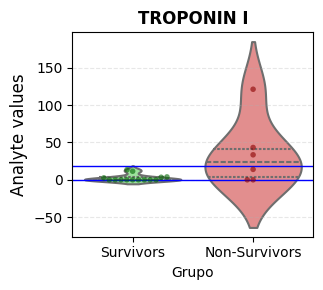

------------------------------------------------------------

Lab. Test: Oxygen Pressure (pO2)


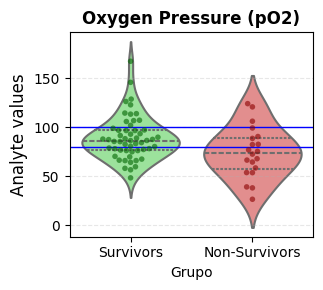

------------------------------------------------------------

Lab. Test: Oxygen Saturation (SaO2)


/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 14.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


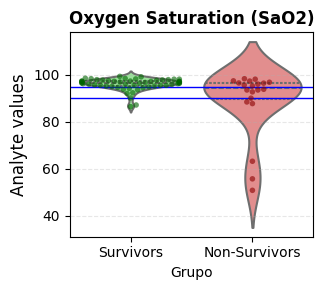

------------------------------------------------------------

Lab. Test: Platelet Count


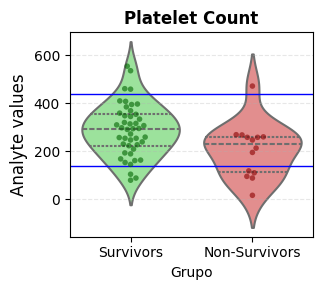

------------------------------------------------------------

Lab. Test: Immature Granulocytes


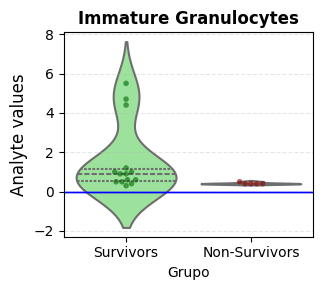

------------------------------------------------------------

Lab. Test: Total creatine kinase


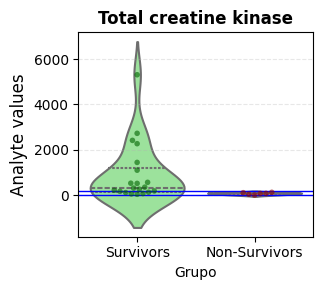

------------------------------------------------------------

Lab. Test: Glucose


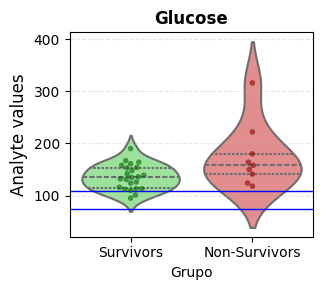

------------------------------------------------------------

Lab. Test: AST (Aspartate Aminotransferase)


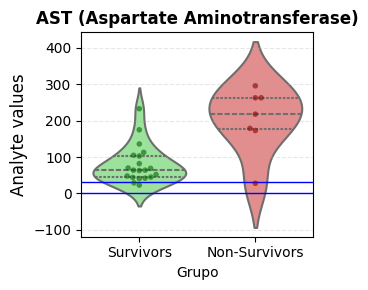

------------------------------------------------------------

Lab. Test: Lactate Dehydrogenase (LDH)


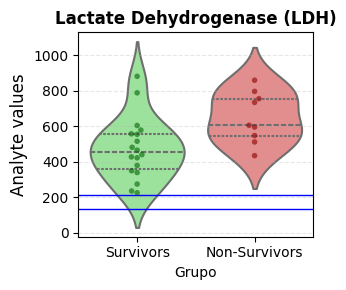

------------------------------------------------------------

Lab. Test: Ferritin


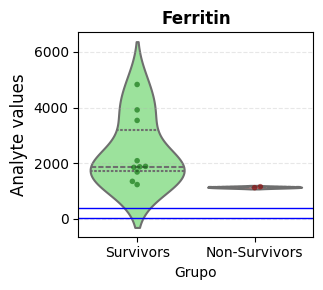

------------------------------------------------------------


Summary - Significant tests:
['TROPONIN I', 'Oxygen Pressure (pO2)', 'Oxygen Saturation (SaO2)', 'Platelet Count', 'Immature Granulocytes', 'Total creatine kinase', 'Glucose', 'AST (Aspartate Aminotransferase)', 'Lactate Dehydrogenase (LDH)', 'Ferritin']


In [87]:
# Filter rows where statistical significance is present (different from 'ns' or empty)
# This selects analytes with p < 0.10 significance threshold described in "Comparative statistical analysis"
filas_significativas = estadisticas[
    ((estadisticas['Non-parametric significance'] != 'ns') &
     (estadisticas['Non-parametric significance'].notna()) &
     (estadisticas['Non-parametric significance'] != '')) |
    ((estadisticas['parametric significance'] != 'ns') &
     (estadisticas['parametric significance'].notna()) &
     (estadisticas['parametric significance'] != ''))
]

# Display laboratory tests with statistical significance
# These correspond to analytes included in the visualizations (Figure 1)
print("Laboratory tests with statistical significance:")
print("=" * 60)

# Iterate through each statistically significant analyte to generate distribution visualizations
# This creates the violin plots referenced in "Data Visualization" section
for idx, fila in filas_significativas.iterrows():
    print(f"\nLab. Test: {fila['Lab. Test']}")

    # Retrieve reference ranges for clinical context
    # Reference ranges provide physiological context for biomarker interpretation
    opt = query(f"SELECT GRUPO, MINIMO, MAXIMO, UNIDAD FROM Param WHERE TEST='{fila['Lab. Test']}'")
    Reference_ranges_MIN = opt.MINIMO[0]
    Reference_ranges_MAX = opt.MAXIMO[0]

    # Prepare data for visualization by combining survivor and non-survivor groups
    # Implements single-point ICU admission analysis methodology
    sobrevivientes_temp = sobrevivientes[[fila['Lab. Test']]].copy()
    sobrevivientes_temp['Grupo'] = 'Survivors'

    muertos_temp = muertos[[fila['Lab. Test']]].copy()
    muertos_temp['Grupo'] = 'Non-Survivors'

    datos_combinados = pd.concat([sobrevivientes_temp, muertos_temp], ignore_index=True)

    # Create figure with specific dimensions for multi-panel display
    # Consistent with visualization approach described in manuscript
    plt.figure(figsize=(10/3, 6/2))

    # Generate violin plot showing complete distribution shape
    # As described in "Data Visualization": "Violin plots were employed to display the complete distribution shape"
    sns.violinplot(data=datos_combinados, x='Grupo', y=fila['Lab. Test'], hue='Grupo',
                   palette={'Survivors': 'lightgreen', 'Non-Survivors': 'lightcoral'},
                   inner='quartile',  # Display quartile lines indicating IQR and median
                   linewidth=1.5)

    # Overlay individual data points using swarm plot
    # "Individual data points were overlaid using swarm plots" - Data Visualization section
    sns.swarmplot(data=datos_combinados, x='Grupo', y=fila['Lab. Test'], hue='Grupo',
                  palette={'Survivors': 'darkgreen', 'Non-Survivors': 'darkred'},
                  alpha=0.6, size=4)

    # Add horizontal reference lines for clinical ranges
    # "Clinical reference ranges, when available, were indicated by horizontal blue lines"
    plt.axhline(y=Reference_ranges_MIN, color='blue', linestyle='-', linewidth=1,
                label=f'Minimum Range: {Reference_ranges_MIN}')
    plt.axhline(y=Reference_ranges_MAX, color='blue', linestyle='-', linewidth=1,
                label=f'Maximum Range: {Reference_ranges_MAX}')

    # Configure plot aesthetics
    plt.title(fila['Lab. Test'], fontsize=12, fontweight='bold')
    plt.ylabel('Analyte values', fontsize=12)
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    # Apply tight layout for multi-plot display
    plt.tight_layout()
    plt.show()

    print("-" * 60)

# Display summary of significant tests
# These represent the analytes with meaningful intergroup differences
print("\n\nSummary - Significant tests:")
print(filas_significativas['Lab. Test'].tolist())